# Predicting Mental Health Treatment at US Companies

__Objective:__ Analyze responses to a 2014 mental health survey to isolate the predictors for whether an employee at a US company will seek mental health treatment

__Data:__ ([Source](https://www.kaggle.com/osmi/mental-health-in-tech-survey))
- 2014 survey 
- Explores mental health attitudes & frequency of mental health disorders in workplace
- Focuses primarily on demographic information and workplace environment characteristics
- 1259 responses, 27 questions / features

__Data Dictionary:__

- __Timestamp__
- __Age__
- __Gender__
- __Country__
- __state__ - If you live in the United States, which state or territory do you live in?
- __self_employed__
- __family_history__ - Do you have a family history of mental illness?
- __treatment__ - Have you sought treatment for a mental health condition?
- __work_interfere__ - If you have a mental health condition, do you feel that it interferes with your work?
- __no_employees__ - How many employees does your company or organization have?
- __remote_work__ - Do you work remotely at least 50% of the time?
- __tech_company__ - Is your employer primarily a tech company?
- __benefits__ - Does your employer provide mental health benefits?
- __care_options__ - Do you know the options for mental health care your employer provides?
- __wellness_program__ - Has your employer ever discussed mental health as part of an employee wellness program?
- __seek_help__ - Does your employer provide resources for seeking mental health help?
- __anonymity__ - Is your anonymity protected if you choose to use mental health resources?
- __leave__ - How easy is it for you to take medical leave for a mental health condition?
- __mental_health_consequence__ - Do you think that discussing a mental health issue with your employer would have negative consequences?
- __phys_health_consequence__ - Do you think that discussing a physical health issue with your employer would have negative consequences?
- __coworkers__ - Would you be willing to discuss a mental health issue with your coworkers?
- __supervisor__ - Would you be willing to discuss a mental health issue with your supervisor(s)?
- __mental_health_interview__ - Would you bring up a mental health issue with a potential employer in an interview?
- __phys_health_interview__ - Would you bring up a physical health issue with a potential employer in an interview?
- __mental_vs_physical__ - Do you feel your employer takes mental health as seriously as physical health?
- __obs_consequence__ - Have you heard of or observed negative consequences for coworkers with mental health conditions?
- __comments__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import ensemble
from sklearn.svm import SVC
from collections import Counter
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, cross_val_score

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.decomposition import PCA

raw_data = pd.read_csv('./data/mental_health_tech.csv', encoding="ISO-8859-1")
us_data = raw_data[raw_data['Country'] == 'United States']

print('Features:\n', list(raw_data.columns), '\n')
print('Total – ', raw_data.shape[0], 'Rows;', raw_data.shape[1], 'Columns')
print('USA - ', us_data.shape[0], 'Rows;', us_data.shape[1], 'Columns\n')

raw_data.head()

Features:
 ['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'comments'] 

Total –  1259 Rows; 27 Columns
USA -  751 Rows; 27 Columns



,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [2]:
for col in raw_data.columns:
    uniq_vals = raw_data[col].unique()
    nan_vals = raw_data[col].isnull().sum()
    if len(uniq_vals) < 8:
        print(col, '-', uniq_vals)
    else:
        print(col, '-', len(uniq_vals), 'uniq vals')
    print('   ***', nan_vals, 'NaNs') if nan_vals > 0 else ''
    print(raw_data[col].value_counts()) if nan_vals > 0 and col not in ['state', 'comments'] else ''

Timestamp - 1246 uniq vals
Age - 53 uniq vals
Gender - 49 uniq vals
Country - 48 uniq vals
state - 46 uniq vals
   *** 515 NaNs
self_employed - [nan 'Yes' 'No']
   *** 18 NaNs
No     1095
Yes     146
Name: self_employed, dtype: int64
family_history - ['No' 'Yes']
treatment - ['Yes' 'No']
work_interfere - ['Often' 'Rarely' 'Never' 'Sometimes' nan]
   *** 264 NaNs
Sometimes    465
Never        213
Rarely       173
Often        144
Name: work_interfere, dtype: int64
no_employees - ['6-25' 'More than 1000' '26-100' '100-500' '1-5' '500-1000']
remote_work - ['No' 'Yes']
tech_company - ['Yes' 'No']
benefits - ['Yes' "Don't know" 'No']
care_options - ['Not sure' 'No' 'Yes']
wellness_program - ['No' "Don't know" 'Yes']
seek_help - ['Yes' "Don't know" 'No']
anonymity - ['Yes' "Don't know" 'No']
leave - ['Somewhat easy' "Don't know" 'Somewhat difficult' 'Very difficult'
 'Very easy']
mental_health_consequence - ['No' 'Maybe' 'Yes']
phys_health_consequence - ['No' 'Yes' 'Maybe']
coworkers - ['Som

## Clean Data

First, I will get rid of invalid ages (below 0 or above 120).

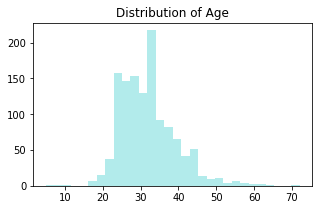

5 rows dropped for invalid ages


In [3]:
orig_num_rows = raw_data.shape[0]

plt.figure(figsize=(5,3))

raw_data = raw_data[raw_data['Age'] > 0]
raw_data = raw_data[raw_data['Age'] < 120]

plt.hist(raw_data['Age'], alpha=0.3, bins=30, color='c')
plt.title('Distribution of Age')
plt.show()

new_num_rows = raw_data.shape[0]
print(orig_num_rows - new_num_rows, 'rows dropped for invalid ages')

Next, I will clean the 'Gender' values to be in 1 of 4 main categories – male, female, or other (non-binary or N/A). Considering that the value count for the 'other' category is very low, I will remove those rows from the dataset.

In [4]:
def get_gender(gender):
    if ' male' in gender or gender in ['m', 'mail', 'maile', 'make', 'mal', 'malr', 'man', 'msle'] or gender.startswith('male') or gender.startswith('guy'):
        return 'male'
    elif gender in ['f', 'femail', 'femake', 'woman'] or gender.startswith('female'):
        return 'female'
    else:
        return 'other'

raw_data['Gender'] = raw_data['Gender'].str.lower().str.replace('cis', '').str.strip()
raw_data['Gender'] = raw_data['Gender'].str.replace('-', '').str.replace(r"\(.*\)","")
raw_data['Gender'] = raw_data['Gender'].apply(get_gender)
raw_data['Gender'].value_counts()

male      992
female    249
other      13
Name: Gender, dtype: int64

In [5]:
orig_num_rows = raw_data.shape[0]

raw_data = raw_data[raw_data['Gender'] != 'other']

new_num_rows = raw_data.shape[0]
print(orig_num_rows - new_num_rows, 'rows dropped for "other" genders')

13 rows dropped for "other" genders


Next, I will handle missing values in my dataset. 

There are 2 main features I will be focusing on for this: 'work_interfere' and 'self_employed'. 

I will impute missing values in the 'work_interfere' column to be the most common response (in this case, 'Sometimes'). I will also drop < 20 rows of data to get rid of NaNs in the 'self_employed' column. 

In [6]:
print(raw_data['work_interfere'].isnull().sum(), 'NaN work_interfere rows to impute')
print(raw_data['work_interfere'].value_counts(), '\n')

raw_data['work_interfere'] = raw_data['work_interfere'].fillna(value='Sometimes')
print(raw_data['work_interfere'].value_counts())

263 NaN work_interfere rows to impute
Sometimes    457
Never        212
Rarely       170
Often        139
Name: work_interfere, dtype: int64 

Sometimes    720
Never        212
Rarely       170
Often        139
Name: work_interfere, dtype: int64


In [7]:
# Drop NaN rows for 'self_employed'
orig_num_rows = raw_data.shape[0]
print(orig_num_rows, 'rows before dropping NaNs')

raw_data = raw_data.dropna(subset=['self_employed'])
new_num_rows = raw_data.shape[0]

print('   -', orig_num_rows - new_num_rows, 'rows dropped')
print('   -', round(new_num_rows/(orig_num_rows) * 100, 2), '% rows left')

1241 rows before dropping NaNs
   - 18 rows dropped
   - 98.55 % rows left


## Feature Engineering

### Continent 

I will use the surprisingly clean 'Country' data to engineer a new feature for 'Continent', to see if there are any patterns to be seen for mental health across different global regions.

In [8]:
def get_continent(country):
    if country in ['United States', 'Canada', 'Mexico', 'Bahamas, The', 'Costa Rica']:
        return 'North America'
    elif country in ['Brazil', 'Colombia', 'Uruguay']:
        return 'South America'
    elif country in ['India', 'Singapore', 'Japan', 'Thailand', 'China', 'Philippines', 'Israel', 'Georgia']:
        return 'Asia'
    elif country in ['South Africa', 'Nigeria']:
        return 'Africa'
    elif country in ['Australia', 'New Zealand']:
        return 'Oceania'
    else:
        return 'Europe'
raw_data['Continent'] = raw_data['Country'].apply(get_continent)
raw_data['Continent'].unique()

array(['North America', 'Europe', 'Oceania', 'South America', 'Asia',
       'Africa'], dtype=object)

### Year, Season

I will also engineer some new time features ('Year' and 'Season') based on the 'Timestamp' feature.

In [9]:
def get_season(timestamp):
    month = timestamp.month
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

raw_data['Year'] = pd.to_datetime(raw_data['Timestamp']).apply(lambda x: x.year)
raw_data['Season'] = pd.to_datetime(raw_data['Timestamp']).apply(get_season)
raw_data.drop(labels='Timestamp', axis=1, inplace=True)
raw_data[['Year', 'Season']].head()

,Year,Season
18,2014,Summer
19,2014,Summer
20,2014,Summer
21,2014,Summer
22,2014,Summer


### Regions

In [10]:
def get_region(state):
    if state in ['CA', 'WA', 'UT', 'NM', 'OR', 'AZ', 'CO', 'NV', 'ID', 'SD', 'WY']:
        return 'West'
    elif state in ['MD', 'NY', 'MA', 'PA', 'CT', 'DC', 'WV', 'VA', 'NH', 'ME', 'NJ', 'VT', 'RI']:
        return 'East'
    elif state in ['TX', 'NC', 'TN', 'FL', 'GA', 'OK', 'KY', 'LA', 'AL', 'SC', 'MS']:
        return 'South'
    elif state in ['IA', 'OH', 'WI', 'IN', 'MI', 'IL', 'MN', 'MO', 'NE', 'KS']:
        return 'Midwest'
    else:
        return state

raw_data['region'] = raw_data['state'].apply(get_region)

## Mental vs. Physical Comparison

I will engineer 2 new features ('mental_phys_consequence' and 'mental_phys_interview') to express whether an employee feels greater trepidation about mentioning mental vs. physical health issues (at work or in an interview):
- 'mental_health_consequence' vs. 'phys_health_consequence'
- 'mental_health_interview' vs. 'phys_health_interview'

In [11]:
these_cols = ['mental_health_consequence', 'phys_health_consequence', 'mental_health_interview', 'phys_health_interview'] 
choices = ['No', 'Maybe', 'Yes']

for col in these_cols:
    print(col)
    print(raw_data[col].value_counts(), '\n')

def get_mental_phys_feat(mental, phys):
    if choices.index(mental) < choices.index(phys):
        return 'Physical'
    elif choices.index(mental) > choices.index(phys):
        return 'Mental'
    else:
        return 'Same'

def get_mental_vs_phys_features(row):
    row['mental_phys_consequence'] = get_mental_phys_feat(row['mental_health_consequence'], row['phys_health_consequence'])
    row['mental_phys_interview'] = get_mental_phys_feat(row['mental_health_interview'], row['phys_health_interview'])
    return row

raw_data = raw_data.apply(get_mental_vs_phys_features, axis=1)

mental_health_consequence
No       475
Maybe    466
Yes      282
Name: mental_health_consequence, dtype: int64 

phys_health_consequence
No       899
Maybe    269
Yes       55
Name: phys_health_consequence, dtype: int64 

mental_health_interview
No       988
Maybe    199
Yes       36
Name: mental_health_interview, dtype: int64 

phys_health_interview
Maybe    543
No       486
Yes      194
Name: phys_health_interview, dtype: int64 



### Comment Features

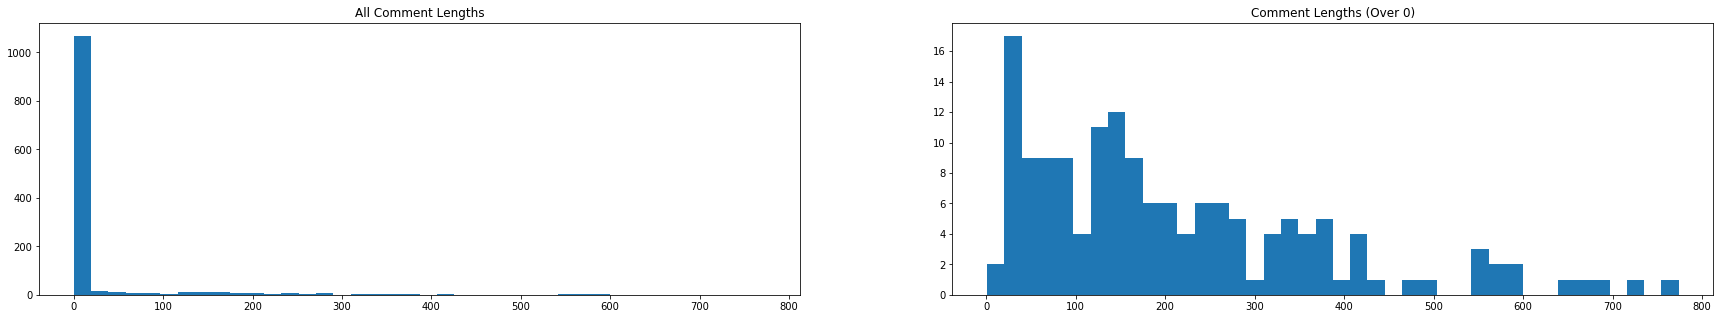

Example comments: [nan, 'Relatively new job. Ask again later', 'Sometimes I think  about using drugs for my mental health issues. If i use drugs I feel better', 'I selected my current employer based on its policies about self care and the quality of their overall health and wellness benefits. I still have residual caution from previous employers who ranged from ambivalent to indifferent to actively hostile regarding mental health concerns.', "Our health plan has covered my psychotherapy and my antidepressant medication. My manager has been aware but discreet throughout. I did get negative reviews when my depression was trashing my delivery but y'know I wasn't delivering.", "I just started a new job last week hence a lot of don't know's"]


In [12]:
num_nan_comments = raw_data['comments'].isnull().sum()
num_valid_comments = raw_data.shape[0] - num_nan_comments

plt.figure(figsize=(30,5))

raw_data['has_comment'] = raw_data['comments'].apply(lambda x: 1 if type(x) is str else 0)
raw_data['comment_lens'] = raw_data['comments'].apply(lambda x: len(x) if type(x) is str else 0)

# Remove 1 extremely long outlier comment
raw_data = raw_data[raw_data['comment_lens'] < 1000]

plt.subplot(1, 2, 1)
plt.hist(raw_data['comment_lens'], bins=40)
plt.title('All Comment Lengths')

plt.subplot(1, 2, 2)
plt.hist(raw_data['comment_lens'][raw_data['comment_lens'] > 0], bins=40)
plt.title('Comment Lengths (Over 0)')

plt.show()

print('Example comments:', list(raw_data['comments'].unique())[:6])

## Explore Data (EDA)

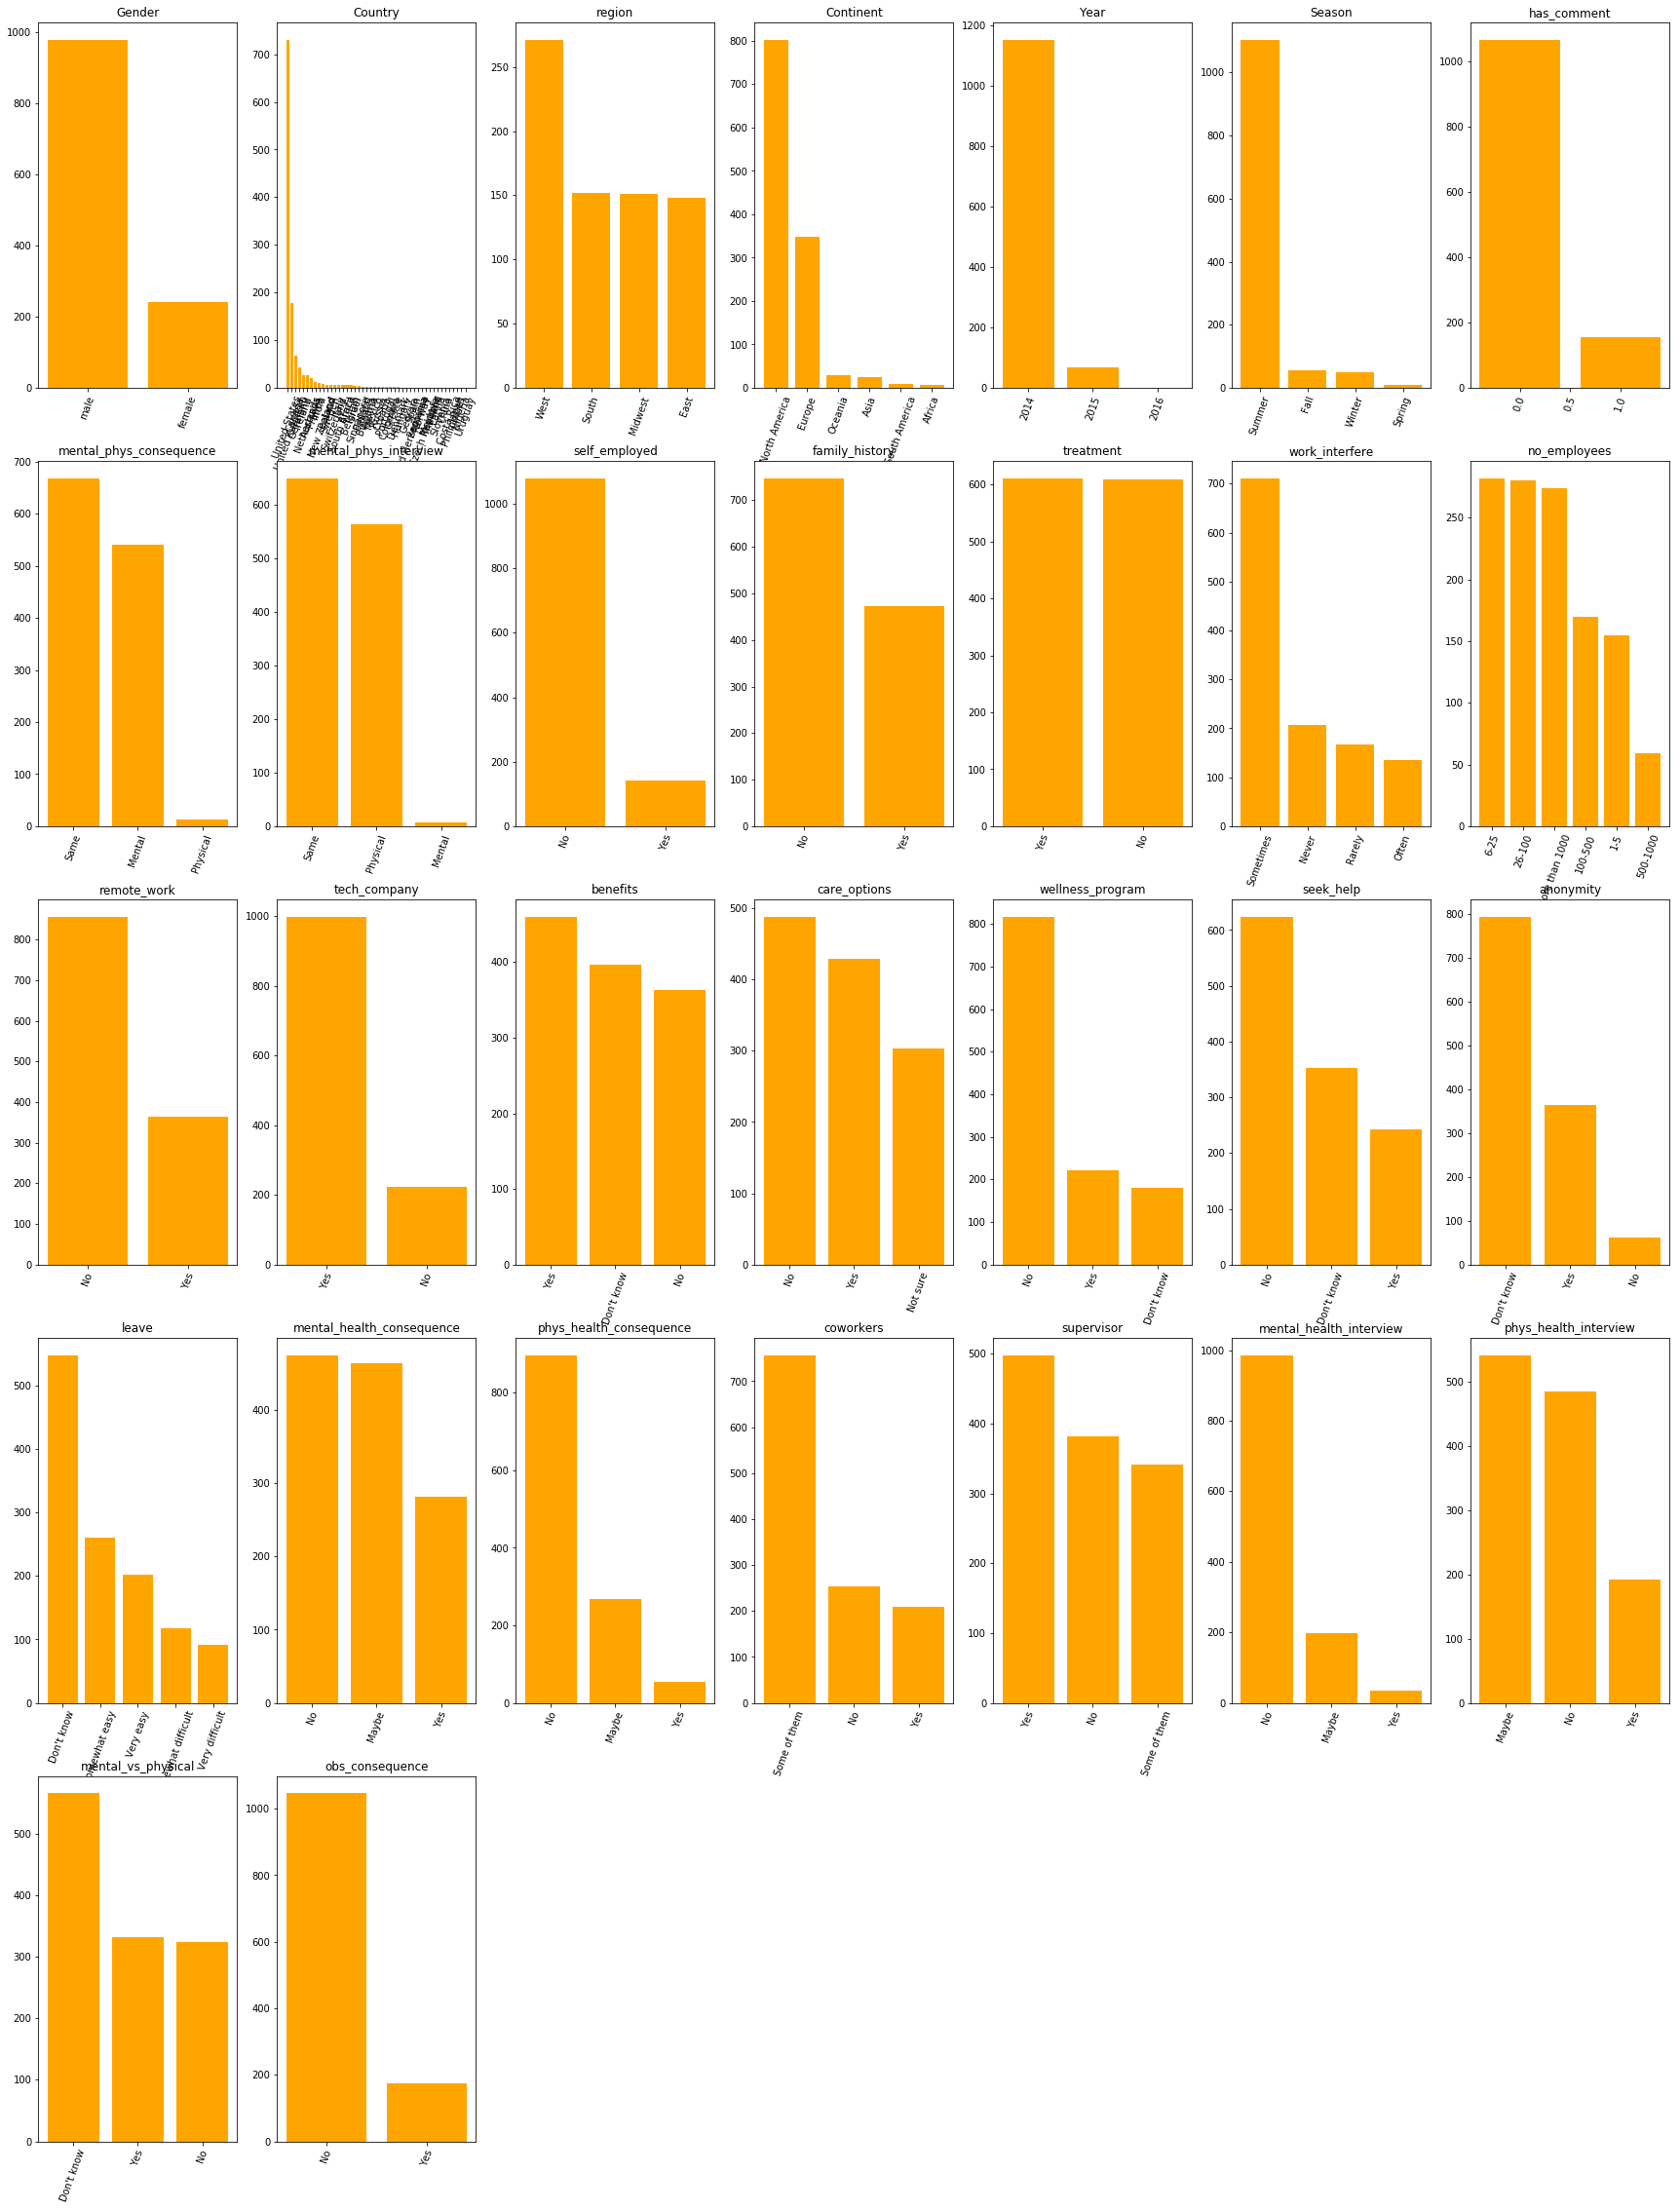

In [13]:
categ_cols = ['Gender', 'Country', 'region', 'Continent', 'Year', 'Season', 'has_comment', 'mental_phys_consequence', 'mental_phys_interview', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company',  'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence']

def show_categs(df, color):
    plt.figure(figsize=(30,40))

    for idx, col in enumerate(categ_cols):
        plt.subplot(5, 7, idx + 1)
        plt.bar(df[col].value_counts().index, height=df[col].value_counts(), color=color)
        plt.xticks(rotation=70)
        plt.title(col)

    plt.show()

show_categs(raw_data, 'orange')

## Narrow Focus

Considering that my data is very dramatically skewed towards people are living in the United States, I will set the scope of my investigation to American employees. 

On this subset of the data, I will attempt to find features that help predict whether an employee seeks treatment for his/her mental health.

730 Rows


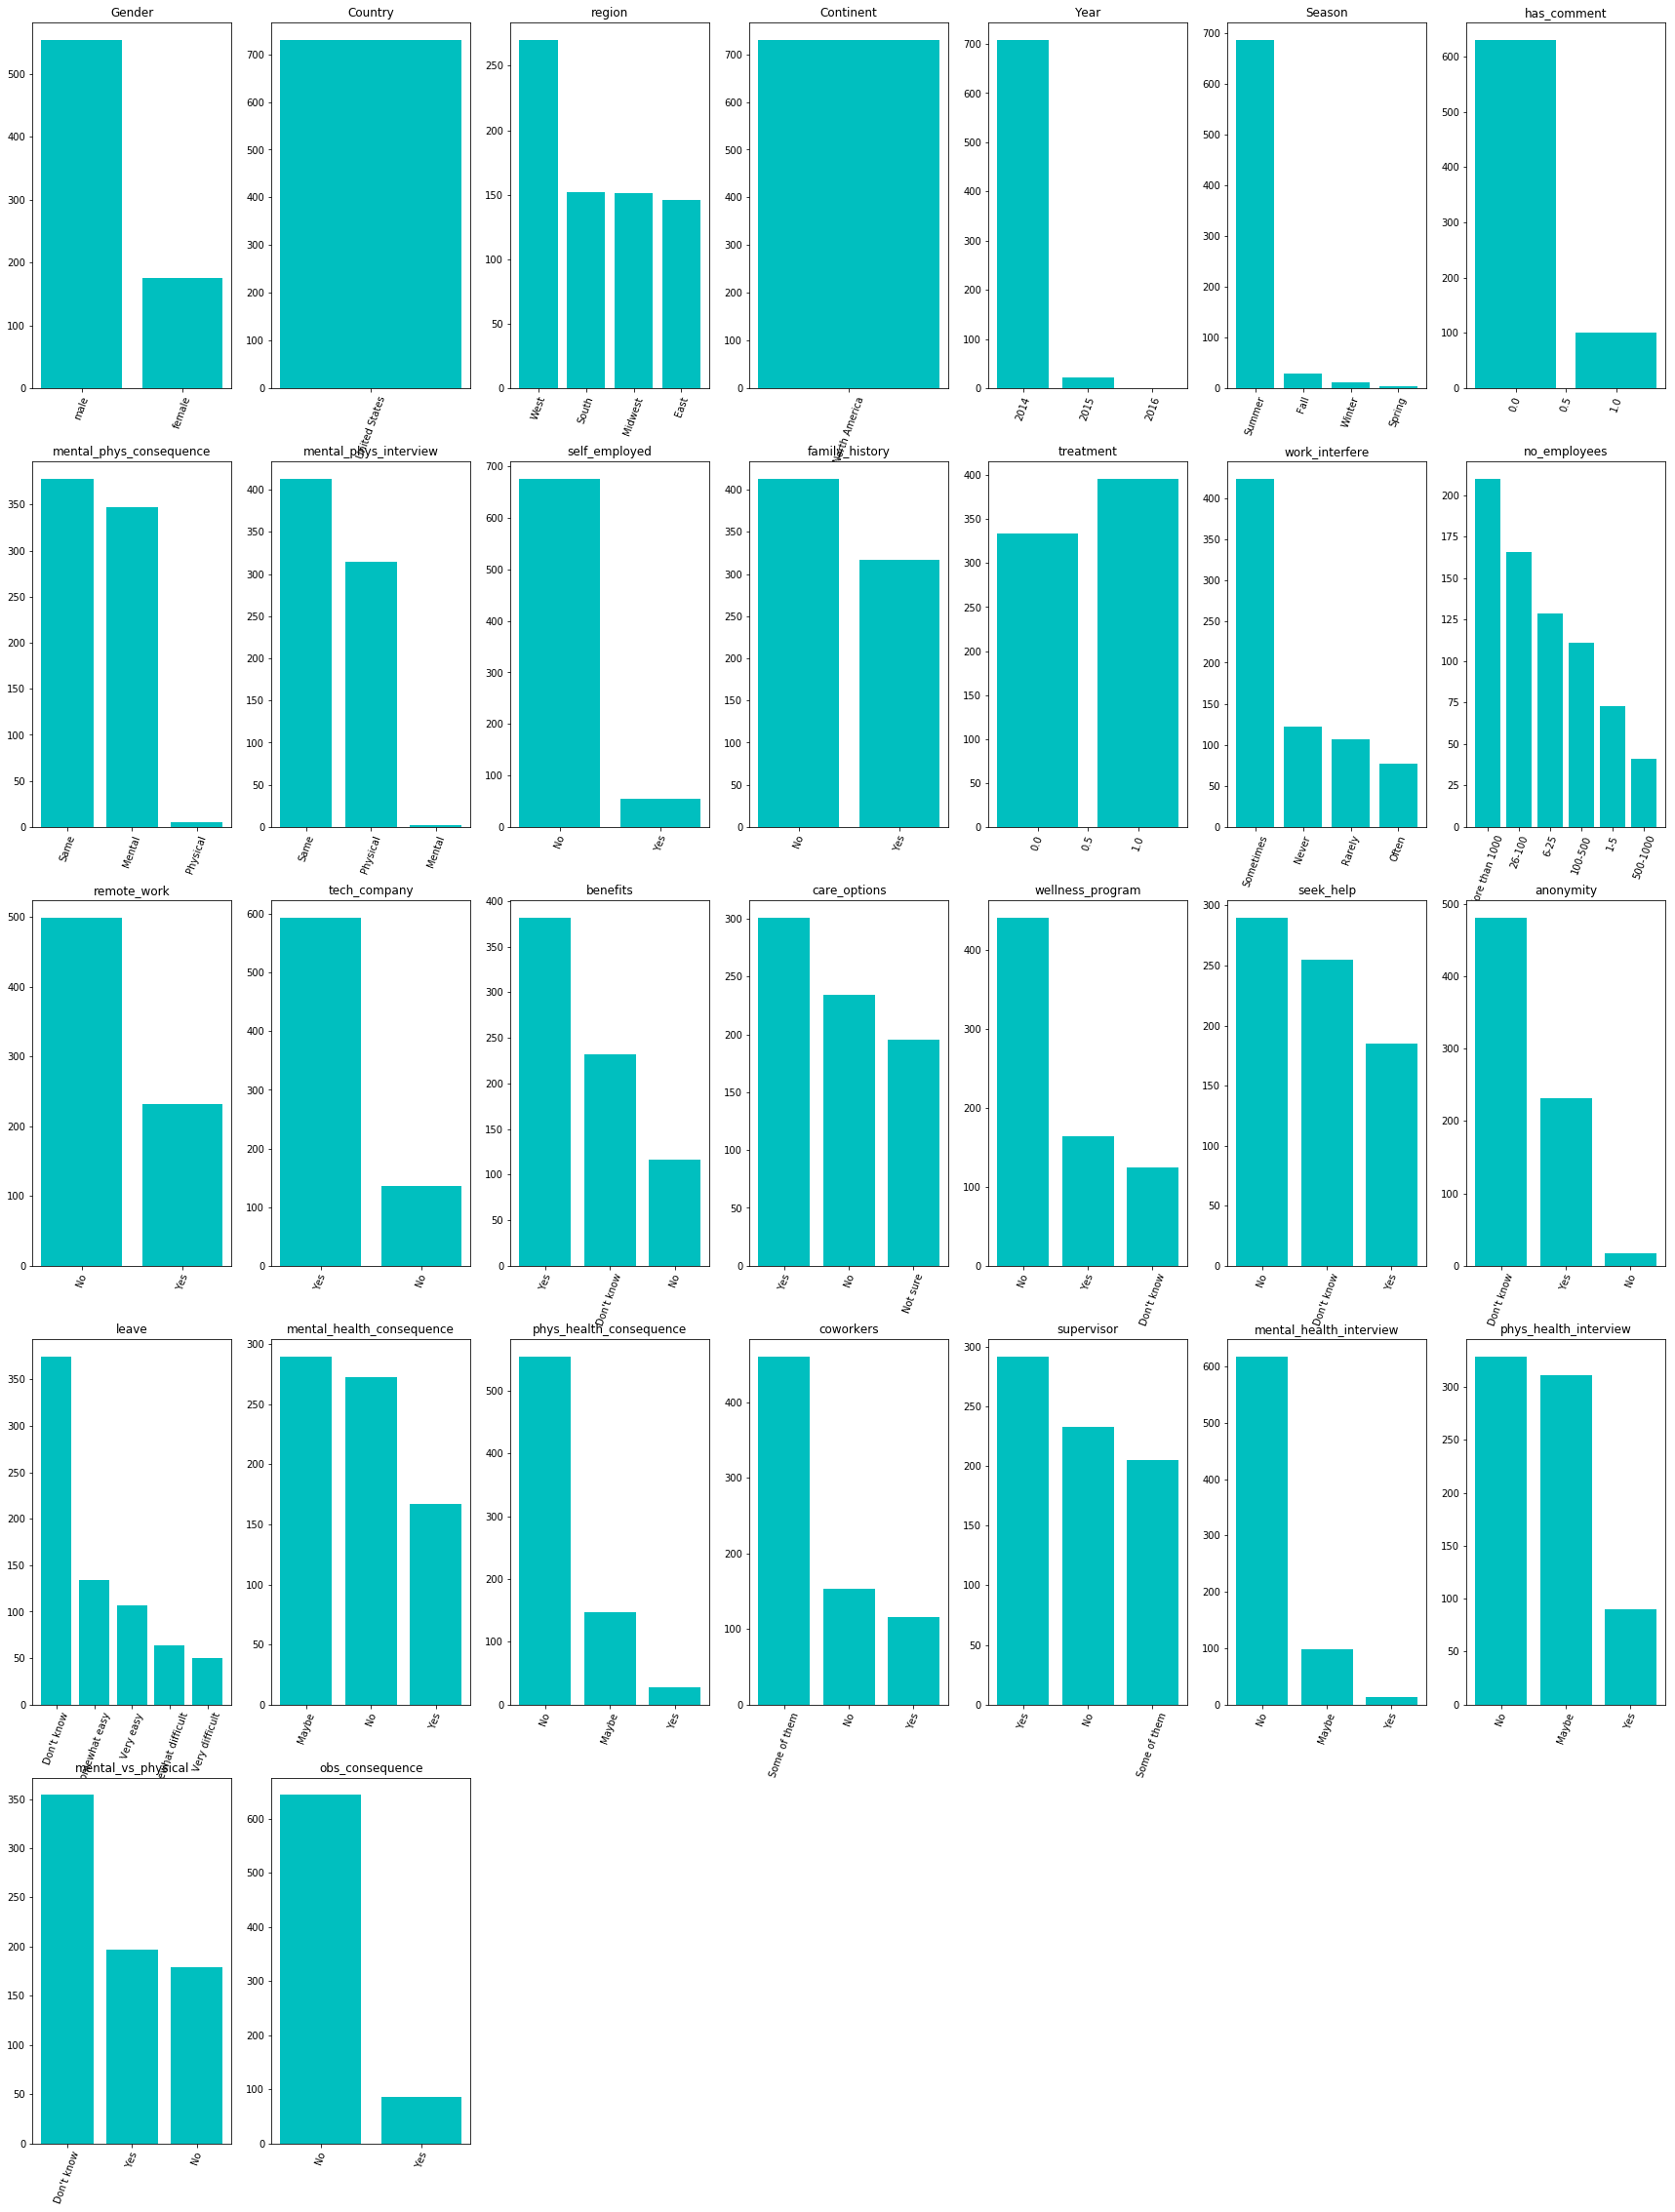

In [14]:
raw_data['treatment'] = raw_data['treatment'].apply(lambda x: 0 if x == 'No' else 1)
raw_data = raw_data[raw_data['Country'] == 'United States']
print(raw_data.shape[0], 'Rows')

show_categs(raw_data, 'c')

## Further Exploratory Data Analysis (EDA)

Before I start building my models to predict my users' mental health treatment, I will first do some preliminary data visualization on features that I believe will have an affect on mental health treatment patterns to see if there are any obvious trends. 

730 Rows
    396 Seeking Treatment; 334 Not


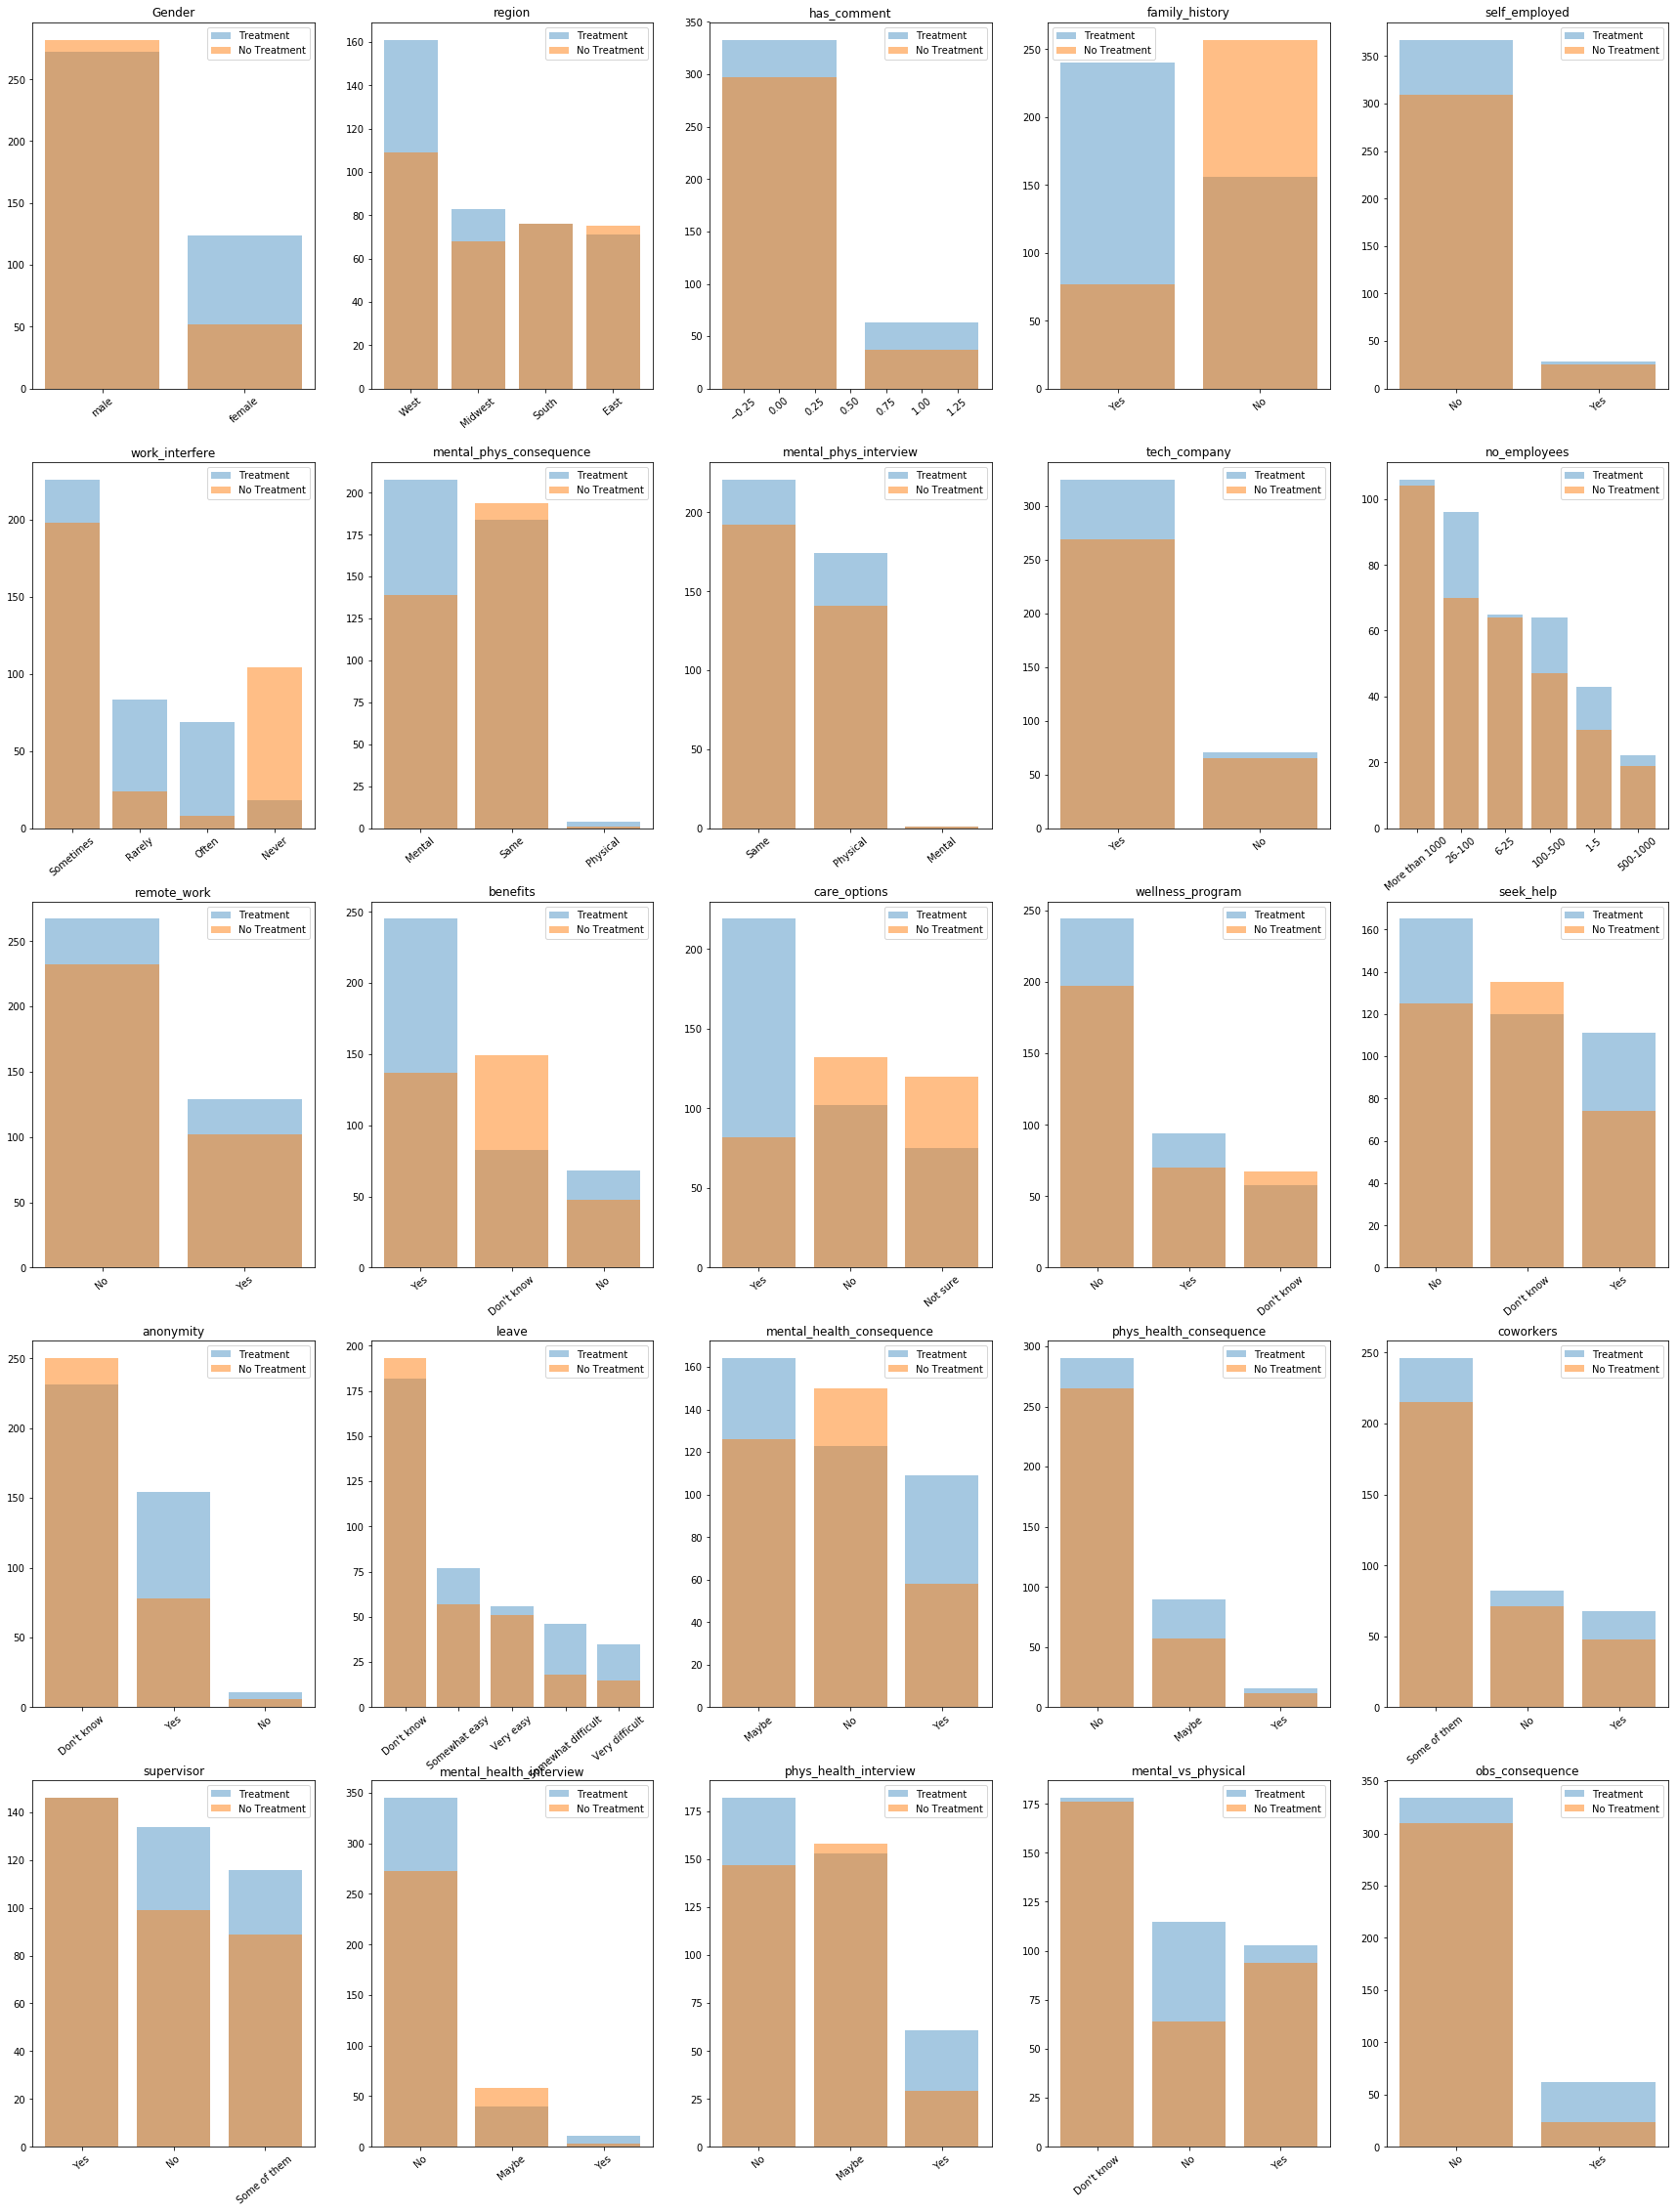

In [15]:
print(raw_data.shape[0], 'Rows')
cols_of_interest = ['Gender', 'region', 'has_comment', 'family_history', 'self_employed', 'work_interfere', 'mental_phys_consequence', 'mental_phys_interview', 'tech_company', 'no_employees', 'remote_work', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence']

def show_visualizations(df, cols_of_interest):
    seek_treatment = df[df['treatment'] == 1]
    no_treatment = df[df['treatment'] == 0]
    print('   ', seek_treatment.shape[0], 'Seeking Treatment;', no_treatment.shape[0], 'Not')
    
    plt.figure(figsize=(30,40))

    for idx, col in enumerate(cols_of_interest):
        plt.subplot(5, 5, idx + 1)
        plt.bar(seek_treatment[col].value_counts().index, height=seek_treatment[col].value_counts(), alpha=0.4, label='Treatment')
        plt.bar(no_treatment[col].value_counts().index, height=no_treatment[col].value_counts(), alpha=0.5, label='No Treatment')
        plt.xticks(rotation=40)
        plt.legend()
        plt.title(col)
    plt.show()
    
show_visualizations(raw_data, cols_of_interest)

raw_data.drop(columns=['state', 'Year', 'Season', 'Country', 'Continent', 'comments'], inplace=True)

I can immediately see a few features that seem to have an effect on whether an employee seeks mental health treatment or not (region, family_history, benefits, etc.), but I also recognize that the disparity in the number of people in each category (those who seek vs. don't seek treatment) is making it difficult to truly compare the groups.

Before I over-sample, I must convert my categorical features into dummies to make sure that I am able to over-sample my minority group (in this case, those not seeking treatment) properly. I will also normalize my own continuous feature ('Age', 'comment_lens') at this time. 

In [16]:
df = raw_data.copy()
df['Age_norm'] = MinMaxScaler().fit_transform(df[['Age']])
df['comment_lens_norm'] = MinMaxScaler().fit_transform(df[['comment_lens']])

cols_to_dummify = list(filter(lambda x: x not in ['Age', 'Age_norm', 'comment_lens', 'comment_lens_norm', 'treatment'], df.columns))

for col in cols_to_dummify:
    dummies = pd.get_dummies(df[col], prefix=col)
    df = df.drop(columns=[col], axis=1)
    df = pd.concat([df, dummies], axis=1)

df.head()

,Age,treatment,comment_lens,Age_norm,comment_lens_norm,Gender_female,Gender_male,self_employed_No,self_employed_Yes,family_history_No,...,region_South,region_West,mental_phys_consequence_Mental,mental_phys_consequence_Physical,mental_phys_consequence_Same,mental_phys_interview_Mental,mental_phys_interview_Physical,mental_phys_interview_Same,has_comment_0,has_comment_1
18,46,0,0,0.611940,0.0,0,1,0,1,0,...,0,0,0,0,1,0,1,0,1,0
20,29,1,0,0.358209,0.0,0,1,1,0,0,...,0,0,1,0,0,0,0,1,1,0
21,31,0,0,0.388060,0.0,0,1,0,1,1,...,1,0,0,0,1,0,1,0,1,0
22,46,1,0,0.611940,0.0,0,1,1,0,1,...,0,0,1,0,0,0,1,0,1,0
23,41,1,0,0.537313,0.0,0,1,1,0,1,...,0,0,1,0,0,0,1,0,1,0


## Over-Sampling to Counter Skewed Data

In [17]:
print(df[df['treatment'] == 0].shape[0])
print(df[df['treatment'] == 1].shape[0])

334
396


In [18]:
train_df = df.loc[::2, :]
test_df = df.loc[1::2, :]

X = df.loc[:, df.columns != 'treatment']
Y = df['treatment']

X_train = train_df.loc[:, train_df.columns != 'treatment']
Y_train = train_df['treatment']

X_test = test_df.loc[:, test_df.columns != 'treatment']
Y_test = test_df['treatment']

sm = SMOTE(random_state=1, ratio = 1.0)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)

print('train set:', Counter(Y_train_res))

over_X_train, over_X_test, over_Y_train, over_Y_test = train_test_split(X_train_res, Y_train_res, test_size=0.3, random_state=10)

train set: Counter({0: 193, 1: 193})


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [19]:
new_df_cols = list(filter(lambda x: x != 'treatment', df.columns))
over_df = pd.DataFrame(data=over_X_train, columns=new_df_cols)
over_df['treatment'] = over_Y_train

print(over_df.shape[0], 'Rows')
print('   ', over_df[over_df['treatment'] == 0].shape[0], 'not seeking treatment')
print('   ', over_df[over_df['treatment'] == 1].shape[0], 'seeking treatment')
over_df.head()

270 Rows
    133 not seeking treatment
    137 seeking treatment


,Age,comment_lens,Age_norm,comment_lens_norm,Gender_female,Gender_male,self_employed_No,self_employed_Yes,family_history_No,family_history_Yes,...,region_West,mental_phys_consequence_Mental,mental_phys_consequence_Physical,mental_phys_consequence_Same,mental_phys_interview_Mental,mental_phys_interview_Physical,mental_phys_interview_Same,has_comment_0,has_comment_1,treatment
0,32.0,0.0,0.402985,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1
1,35.0,31.0,0.447761,0.040052,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1
2,25.0,0.0,0.298507,0.000000,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
3,26.0,0.0,0.313433,0.000000,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1
4,24.0,0.0,0.283582,0.000000,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1


## Creating Initial Supervised Classifying Models

In [20]:
def get_errors(crosstab):
    tI_errors = crosstab.loc[0,1] / crosstab.loc['All','All'] * 100
    tII_errors = crosstab.loc[1,0] / crosstab.loc['All','All'] * 100
    print(('\nType I errors: {}%\nType II errors: {}%\n').format(round(tI_errors, 2), round(tII_errors, 2)))
    
def get_precision_recall(crosstab):
    precision = crosstab.loc[1,1] / crosstab.loc['All', 1] * 100 
    recall = crosstab.loc[1,1] / crosstab.loc[1,'All'] * 100 
    print(('Precision: {}%\nRecall: {}%').format(round(precision, 2), round(recall, 2)))

def fit_and_train(model):
    model_fit = model.fit(over_X_train, over_Y_train)
    model_score_train = model.score(over_X_test, over_Y_test)
    print('***TRAIN***')
    print('R² for train:', model_score_train)
    
    train_crosstab = pd.crosstab(over_Y_train, model_fit.predict(over_X_train), rownames=['actual'], colnames=['predicted'], margins=True)
    print(train_crosstab)
    
    get_errors(train_crosstab)
    get_precision_recall(train_crosstab)
    
    model_score_test = model.score(X_test, Y_test)
    print('\n***TEST***')
    print('R² for test:', model_score_test)
    
    test_crosstab = pd.crosstab(Y_test, model_fit.predict(X_test), rownames=['actual'], colnames=['predicted'], margins=True)
    print(test_crosstab)
    
    get_errors(test_crosstab)
    get_precision_recall(test_crosstab)
    
    model_score_whole = model.score(X, Y)
    print('\n***WHOLE***')
    print('R² for whole:', model_score_whole)
    
    whole_crosstab = pd.crosstab(Y, model_fit.predict(X), rownames=['actual'], colnames=['predicted'], margins=True)
    print(whole_crosstab)
    
    get_errors(whole_crosstab)
    get_precision_recall(whole_crosstab)
    
    if hasattr(model_fit, 'coef_'):
        print('\nCoefficients:', model_fit.coef_)
        
        lasso_important_cols = []
        for col, coef in zip(X.columns, model_fit.coef_[0]):
            if abs(coef) > 0.3:
                lasso_important_cols.append(col)
        print('\n***Important cols***', list(lasso_important_cols))

lasso = linear_model.LogisticRegression(penalty='l1', C=10, random_state=10) 
fit_and_train(lasso)

***TRAIN***
R² for train: 0.7844827586206896
predicted    0    1  All
actual                  
0          112   21  133
1           25  112  137
All        137  133  270

Type I errors: 7.78%
Type II errors: 9.26%

Precision: 84.21%
Recall: 81.75%

***TEST***
R² for test: 0.8136986301369863
predicted    0    1  All
actual                  
0          138   34  172
1           34  159  193
All        172  193  365

Type I errors: 9.32%
Type II errors: 9.32%

Precision: 82.38%
Recall: 82.38%

***WHOLE***
R² for whole: 0.7726027397260274
predicted    0    1  All
actual                  
0          262   72  334
1           94  302  396
All        356  374  730

Type I errors: 9.86%
Type II errors: 12.88%

Precision: 80.75%
Recall: 76.26%

Coefficients: [[-1.54164634e-04 -3.71617963e-04  0.00000000e+00  0.00000000e+00
   6.99610894e-01 -1.06875025e-01  7.92963230e-02 -5.56754158e-01
  -9.26568069e-01  1.40021644e+00 -1.13301921e+00  3.09056835e+00
   1.92588140e+00 -2.61263425e-01  0.00000

***TRAIN***
R² for train: 0.8103448275862069
predicted    0    1  All
actual                  
0          109   24  133
1           24  113  137
All        133  137  270

Type I errors: 8.89%
Type II errors: 8.89%

Precision: 82.48%
Recall: 82.48%

***TEST***
R² for test: 0.8164383561643835
predicted    0    1  All
actual                  
0          135   37  172
1           30  163  193
All        165  200  365

Type I errors: 10.14%
Type II errors: 8.22%

Precision: 81.5%
Recall: 84.46%

***WHOLE***
R² for whole: 0.7780821917808219
predicted    0    1  All
actual                  
0          252   82  334
1           80  316  396
All        332  398  730

Type I errors: 11.23%
Type II errors: 10.96%

Precision: 79.4%
Recall: 79.8%


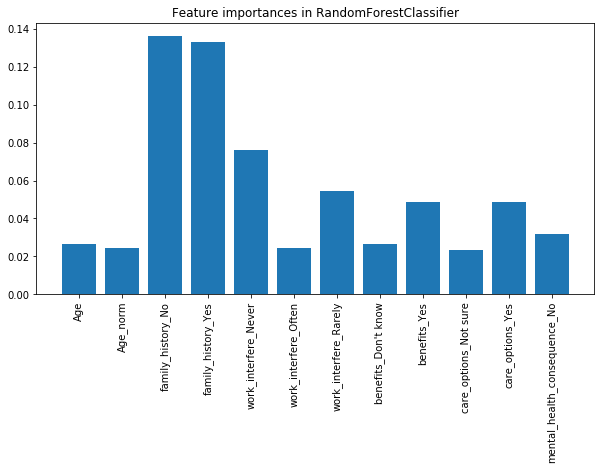

***IMPORTANT COLS:*** ['Age', 'Age_norm', 'family_history_No', 'family_history_Yes', 'work_interfere_Never', 'work_interfere_Often', 'work_interfere_Rarely', "benefits_Don't know", 'benefits_Yes', 'care_options_Not sure', 'care_options_Yes', 'mental_health_consequence_No']


In [21]:
rfc = ensemble.RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=10)
fit_and_train(rfc)

plt.figure(figsize=(10,5))
important_col_bools = (rfc.feature_importances_ > 0.02)
plt.bar(X_train.columns[important_col_bools], height=rfc.feature_importances_[important_col_bools])
plt.xticks(rotation=90)
plt.title('Feature importances in RandomForestClassifier')
plt.show()

important_cols = list(X_train.columns[important_col_bools])
print('***IMPORTANT COLS:***', important_cols)

In [22]:
bnb = BernoulliNB()
fit_and_train(bnb)

***TRAIN***
R² for train: 0.7931034482758621
predicted    0    1  All
actual                  
0          102   31  133
1           33  104  137
All        135  135  270

Type I errors: 11.48%
Type II errors: 12.22%

Precision: 77.04%
Recall: 75.91%

***TEST***
R² for test: 0.7671232876712328
predicted    0    1  All
actual                  
0          128   44  172
1           41  152  193
All        169  196  365

Type I errors: 12.05%
Type II errors: 11.23%

Precision: 77.55%
Recall: 78.76%

***WHOLE***
R² for whole: 0.7506849315068493
predicted    0    1  All
actual                  
0          254   80  334
1          102  294  396
All        356  374  730

Type I errors: 10.96%
Type II errors: 13.97%

Precision: 78.61%
Recall: 74.24%

Coefficients: [[-0.00722025 -1.84343148 -0.00722025 -1.84343148 -1.22090187 -0.34950645
  -0.0441248  -3.14271446 -0.98323021 -0.46856581 -2.63188884 -2.04410218
  -1.5671781  -0.50365713 -2.53657866 -1.6763774  -1.37912587 -2.73724936
  -1.84343148

In [23]:
gbm = ensemble.GradientBoostingClassifier(n_estimators=500, loss='deviance', random_state=10)
fit_and_train(gbm)

***TRAIN***
R² for train: 0.7586206896551724
predicted    0    1  All
actual                  
0          133    0  133
1            0  137  137
All        133  137  270

Type I errors: 0.0%
Type II errors: 0.0%

Precision: 100.0%
Recall: 100.0%

***TEST***
R² for test: 0.9260273972602739
predicted    0    1  All
actual                  
0          159   13  172
1           14  179  193
All        173  192  365

Type I errors: 3.56%
Type II errors: 3.84%

Precision: 93.23%
Recall: 92.75%

***WHOLE***
R² for whole: 0.8164383561643835
predicted    0    1  All
actual                  
0          269   65  334
1           69  327  396
All        338  392  730

Type I errors: 8.9%
Type II errors: 9.45%

Precision: 83.42%
Recall: 82.58%


In [24]:
svm = SVC(C=10, kernel='poly', coef0=0.01, random_state=10)
fit_and_train(svm)

***TRAIN***
R² for train: 0.7241379310344828
predicted    0    1  All
actual                  
0          133    0  133
1            0  137  137
All        133  137  270

Type I errors: 0.0%
Type II errors: 0.0%

Precision: 100.0%
Recall: 100.0%

***TEST***
R² for test: 0.9123287671232877
predicted    0    1  All
actual                  
0          156   16  172
1           16  177  193
All        172  193  365

Type I errors: 4.38%
Type II errors: 4.38%

Precision: 91.71%
Recall: 91.71%

***WHOLE***
R² for whole: 0.7876712328767124
predicted    0    1  All
actual                  
0          272   62  334
1           93  303  396
All        365  365  730

Type I errors: 8.49%
Type II errors: 12.74%

Precision: 83.01%
Recall: 76.52%


## Optimize Most Performant Models with Manually Selected Features (RFC, GBM, & SVM)

In [25]:
train_df = df.loc[::2, :]
test_df = df.loc[1::2, :]

X = df.loc[:, important_cols]
Y = df['treatment']

X_train = train_df.loc[:, important_cols]
Y_train = train_df['treatment']

X_test = test_df.loc[:, important_cols]
Y_test = test_df['treatment']

sm = SMOTE(random_state=1, ratio = 1.0)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)

print('train set:', Counter(Y_train_res))

over_X_train, over_X_test, over_Y_train, over_Y_test = train_test_split(X_train_res, Y_train_res, test_size=0.3, random_state=10)

train set: Counter({0: 193, 1: 193})


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


***TRAIN***
R² for train: 0.8017241379310345
predicted    0    1  All
actual                  
0          107   26  133
1           29  108  137
All        136  134  270

Type I errors: 9.63%
Type II errors: 10.74%

Precision: 80.6%
Recall: 78.83%

***TEST***
R² for test: 0.7917808219178082
predicted    0    1  All
actual                  
0          132   40  172
1           36  157  193
All        168  197  365

Type I errors: 10.96%
Type II errors: 9.86%

Precision: 79.7%
Recall: 81.35%

***WHOLE***
R² for whole: 0.7589041095890411
predicted    0    1  All
actual                  
0          247   87  334
1           89  307  396
All        336  394  730

Type I errors: 11.92%
Type II errors: 12.19%

Precision: 77.92%
Recall: 77.53%


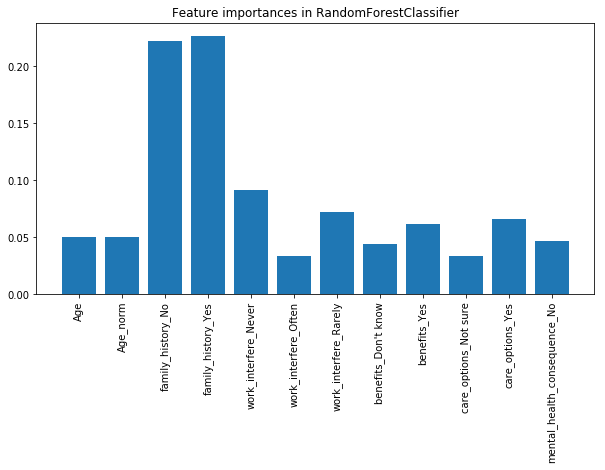

In [26]:
rfc = ensemble.RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=10)
fit_and_train(rfc)

plt.figure(figsize=(10,5))
plt.bar(X_train.columns, height=rfc.feature_importances_)
plt.xticks(rotation=90)
plt.title('Feature importances in RandomForestClassifier')
plt.show()

In [27]:
gbm = ensemble.GradientBoostingClassifier(n_estimators=500, loss='deviance', random_state=10)
fit_and_train(gbm)

***TRAIN***
R² for train: 0.7672413793103449
predicted    0    1  All
actual                  
0          129    4  133
1            6  131  137
All        135  135  270

Type I errors: 1.48%
Type II errors: 2.22%

Precision: 97.04%
Recall: 95.62%

***TEST***
R² for test: 0.8986301369863013
predicted    0    1  All
actual                  
0          156   16  172
1           21  172  193
All        177  188  365

Type I errors: 4.38%
Type II errors: 5.75%

Precision: 91.49%
Recall: 89.12%

***WHOLE***
R² for whole: 0.7849315068493151
predicted    0    1  All
actual                  
0          271   63  334
1           94  302  396
All        365  365  730

Type I errors: 8.63%
Type II errors: 12.88%

Precision: 82.74%
Recall: 76.26%


In [28]:
svm = SVC(C=10, kernel='poly', coef0=0.1, random_state=10)
fit_and_train(svm)

***TRAIN***
R² for train: 0.7931034482758621
predicted    0    1  All
actual                  
0          101   32  133
1           23  114  137
All        124  146  270

Type I errors: 11.85%
Type II errors: 8.52%

Precision: 78.08%
Recall: 83.21%

***TEST***
R² for test: 0.7890410958904109
predicted    0    1  All
actual                  
0          128   44  172
1           33  160  193
All        161  204  365

Type I errors: 12.05%
Type II errors: 9.04%

Precision: 78.43%
Recall: 82.9%

***WHOLE***
R² for whole: 0.7493150684931507
predicted    0    1  All
actual                  
0          244   90  334
1           93  303  396
All        337  393  730

Type I errors: 12.33%
Type II errors: 12.74%

Precision: 77.1%
Recall: 76.52%


## PCA For Most Performant Models (RFC, GBM, & SVM)

10 Components
      [2711.29599677  209.96071278   30.62602444   26.45117737   24.79657247
   23.18284104   19.17006735   18.63740105   18.25069596   17.71661626]
5 Components
      [2711.29599677  209.96071278   30.62602762   26.45122856   24.79668502]
3 Components
      [2711.29599677  209.96071278   30.62602761]


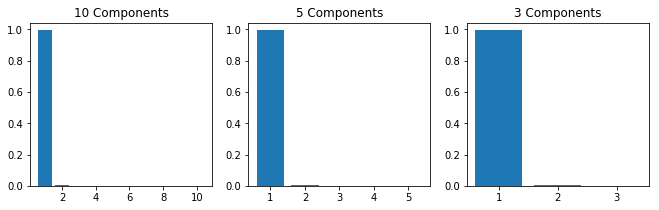

(730, 4)


,feat_1,feat_2,feat_3,treatment
0,-31.104526,12.989342,1.736202,0
1,-31.135881,-4.028294,-0.266263,1
2,-31.131868,-2.022618,0.754655,0
3,-31.106875,12.986556,-0.718248,1
4,-31.117564,7.960979,-1.855869,1


In [29]:
X = df.loc[:, df.columns != 'treatment']
Y = df['treatment']

plt.figure(figsize=(15,3))

for idx, num_components in enumerate([10, 5, 3]):
    pca = PCA(n_components=num_components)
    Y_sklearn = pca.fit_transform(X)
    print(num_components, 'Components')
    print('     ', pca.singular_values_)
    
    plt.subplot(1, 4, idx + 1)
    plt.bar(list(range(1, num_components + 1)), height=pca.explained_variance_ratio_)
    plt.title(str(num_components) + ' Components')
plt.show()

pca_df = pd.DataFrame(data=Y_sklearn, columns=['feat_1', 'feat_2', 'feat_3'])
pca_df['treatment'] = Y.values
pca_df = pca_df.reset_index().drop(columns='index')

print(pca_df.shape)
pca_df.head()

In [30]:
train_df = pca_df.loc[::2, :]
test_df = pca_df.loc[1::2, :]

X = pca_df.loc[:, pca_df.columns != 'treatment']
Y = pca_df['treatment']

X_train = train_df.loc[:, pca_df.columns != 'treatment']
Y_train = train_df['treatment']

X_test = test_df.loc[:, pca_df.columns != 'treatment']
Y_test = test_df['treatment']

sm = SMOTE(random_state=1, ratio = 1.0)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)

print('train set:', Counter(Y_train_res))

over_X_train, over_X_test, over_Y_train, over_Y_test = train_test_split(X_train_res, Y_train_res, test_size=0.3, random_state=10)

train set: Counter({0: 193, 1: 193})


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


***TRAIN***
R² for train: 0.6379310344827587
predicted    0    1  All
actual                  
0          104   29  133
1           12  125  137
All        116  154  270

Type I errors: 10.74%
Type II errors: 4.44%

Precision: 81.17%
Recall: 91.24%

***TEST***
R² for test: 0.547945205479452
predicted    0    1  All
actual                  
0           78   84  162
1           81  122  203
All        159  206  365

Type I errors: 23.01%
Type II errors: 22.19%

Precision: 59.22%
Recall: 60.1%

***WHOLE***
R² for whole: 0.6671232876712329
predicted    0    1  All
actual                  
0          202  132  334
1          111  285  396
All        313  417  730

Type I errors: 18.08%
Type II errors: 15.21%

Precision: 68.35%
Recall: 71.97%


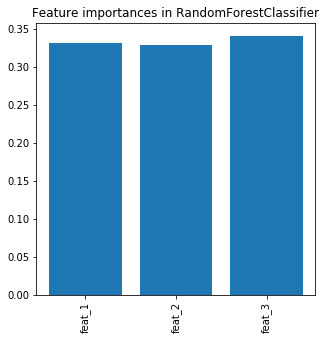

In [31]:
rfc = ensemble.RandomForestClassifier(n_estimators=500, max_depth=4, random_state=10)
fit_and_train(rfc)

plt.figure(figsize=(5,5))
plt.bar(X_train.columns, height=rfc.feature_importances_)
plt.xticks(rotation=90)
plt.title('Feature importances in RandomForestClassifier')
plt.show()

In [32]:
gbm = ensemble.GradientBoostingClassifier(n_estimators=500, loss='deviance', random_state=10)
fit_and_train(gbm)

***TRAIN***
R² for train: 0.6120689655172413
predicted    0    1  All
actual                  
0          133    0  133
1            0  137  137
All        133  137  270

Type I errors: 0.0%
Type II errors: 0.0%

Precision: 100.0%
Recall: 100.0%

***TEST***
R² for test: 0.5287671232876713
predicted    0    1  All
actual                  
0           77   85  162
1           87  116  203
All        164  201  365

Type I errors: 23.29%
Type II errors: 23.84%

Precision: 57.71%
Recall: 57.14%

***WHOLE***
R² for whole: 0.7054794520547946
predicted    0    1  All
actual                  
0          231  103  334
1          112  284  396
All        343  387  730

Type I errors: 14.11%
Type II errors: 15.34%

Precision: 73.39%
Recall: 71.72%


In [33]:
# svm = SVC(C=10, kernel='poly', coef0=0.1, random_state=10)
# fit_and_train(svm)

## Visualize Findings

At the end, it seems like using all features gave the most accurate results – even more so than manually selecting features with the highest importance, or the new features created by PCA.

Using the full feature set, I will visualize my findings by looking at how my 2 groups (those seeking treatment, and those who are not) differ on the most important features.

    137 Seeking Treatment; 133 Not


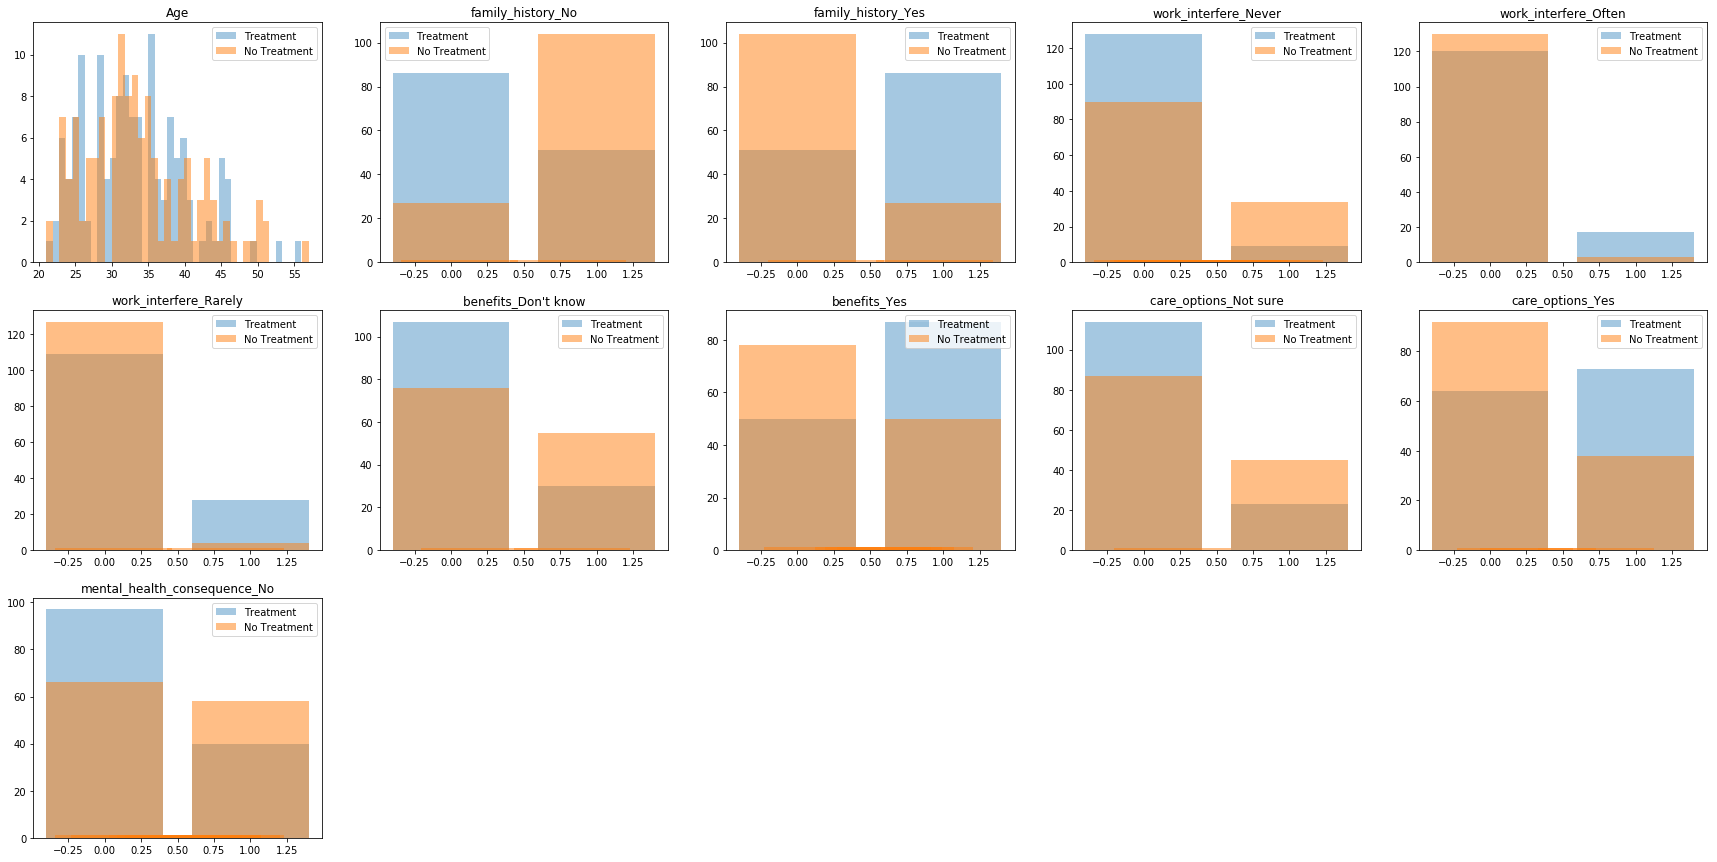

In [34]:
seek_treatment = over_df[over_df['treatment'] == 1]
no_treatment = over_df[over_df['treatment'] == 0]
print('   ', seek_treatment.shape[0], 'Seeking Treatment;', no_treatment.shape[0], 'Not')

plt.figure(figsize=(30,15))
important_cols = list(filter(lambda x: x != 'Age_norm', important_cols))
for idx, col in enumerate(important_cols):
    plt.subplot(3, 5, idx + 1)
    if col == 'Age':
        plt.hist(seek_treatment[col], alpha=0.4, bins=40, label='Treatment')
        plt.hist(no_treatment[col], alpha=0.5, bins=40, label='No Treatment')
        plt.legend()
        plt.title(col)
    else:
        plt.bar(seek_treatment[col].value_counts().index, height=seek_treatment[col].value_counts(), alpha=0.4, label='Treatment')
        plt.bar(no_treatment[col].value_counts().index, height=no_treatment[col].value_counts(), alpha=0.5, label='No Treatment')
        plt.legend()
        plt.title(col)
plt.show()

## Findings

Looking at the visualizations, it seems like employees who are most likely to seek mental health treatment:
- Are women in late 20s to mid-30s
- Have a family history of mental health issues
- Feel their mental health issues interfere with work, even if rarely
- Have mental health benefits at their workplace, and are informed about these benefits and care options
- Want to avoid discussing mental health with employer (surprising and interesting discovery)

## Conclusion 

As far as my supervised learning models go, my Random Forest Classifier performed the best, especially when I used all relevant features I had engineered.

- When I __used all relevant features__, I had an __overall R² value of ~78%__, with __similar precision and recall rates (~79%)__. __Errors were below ~12%__. 
- When I __manually selected__ my most important features, I had a slightly lower __overall R² value of ~76%__, with similar __precision and recall rates (~78%)__. __Errors were 11% - 12.5%__. 
- When I used __PCA__ to reduce dimensionality to just 3 features, my model performed significantly worse and much more erratically across the 3 different datasets, which led me to believe that this model was overfitted. – I had an __overall R² of ~67%__, and __precision and recall rates between 68%-72%__. __Errors were 15%-18.5%__.

One downside of Random Forest Classifiers is that they are often prone to overfitting. I adjusted some hyperparameters (particularly that of max-depth) to account for this. Before tuning these hyperparameters, my models had slightly higher R² values and higher precision / recall rates, as well as slightly lower errors, but these values were quite erratic across train, test, and overall dataset (thus hinting at over-fitting). I felt that a model that was more consistent, and thus exhibited less variance in the bias-variance tradeoff, was a better overall solution than one that simply gave a high R² value for certain datasets.